In [ ]:
## research paper used  -> https://arxiv.org/pdf/2103.00020 ,https://arxiv.org/html/2406.03865v1 (used this to get an idea of semantic similarity)


## CLIP

In [40]:
import requests
import torch
import torchvision
from torchvision  import datasets,transforms
from torchvision.transforms import ToTensor
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", dtype=torch.bfloat16, attn_implementation="sdpa")
processor =CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32",use_fast=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [41]:
import matplotlib.pyplot as plt

## Exp 1 (CIFAR SET)

In [42]:

train_dataset=torchvision.datasets.CIFAR10('data',train=True,download=True,target_transform=None,transform=None)


In [43]:
len(train_dataset)

50000

In [44]:
classes=train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [45]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [46]:
img,label_idx=train_dataset[2]
label=classes[label_idx]


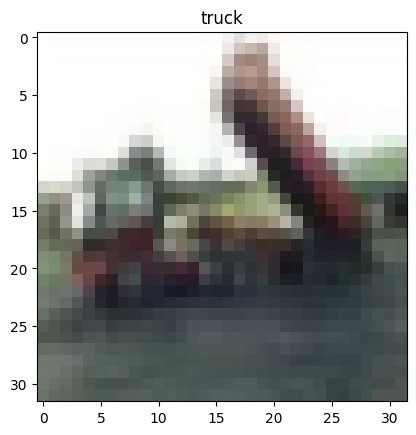

In [47]:
plt.title(label)
plt.imshow(img)

In [48]:
text_prompt = [f"a photo of a {label}" for label in classes]
inputs = processor(
    text=text_prompt,
    images=[img],
    return_tensors="pt",
    padding=True
)

### Similarity score between cat and dog

In [50]:
dataset_a_images=[] # dog
dataset_b_images=[] # cat
dataset_c_images=[] #truck
dataset_d_images=[] #ship

for (img,label) in train_dataset:
  if label=="dog":
    dataset_a_images.append(img)
  elif label=="cat":
    dataset_b_images.append(img)
  elif label=="truck"
    dataset_c_images.append(img)
  elif label=="ship"
    dataset_d_images.append(img)



In [ ]:
from torch.utils import Dataset,Dataloader

class ImageDataset(Dataset):
  def __init__(self,images):
    self.images=images

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    return self.images[idx]

dog_dataset=ImageDataset(dataset_a_images)
cat_dataset=ImageDataset(dataset_b_images)
truck_dataset=ImageDataset(dataset_c_images)
ship_dataset=ImageDataset(dataset_d_images)

dog_loader = DataLoader(dog_dataset, batch_size=32, shuffle=False)
cat_loader = DataLoader(cat_dataset, batch_size=32, shuffle=False)
truck_loader = DataLoader(truck_dataset, batch_size=32, shuffle=False)
ship_loader = DataLoader(ship_dataset, batch_size=32, shuffle=False)

In [ ]:
def extract_embeddings(dataloader,model,processor,device):
  all_embeddings=[]
  model.eval()

  with torch.no_grad():
    for images_batch in dataloader:

            inputs = processor(
                images=images_batch,
                return_tensors="pt"
            ).to(device)


            image_features = model.get_image_features(**inputs)


            all_embeddings.append(image_features.cpu())

    # Concatenate all batches into one big tensor
    # The shape will be [num_images, embedding_dim] (e.g., [5000, 512])
    return torch.cat(all_embeddings, dim=0)


In [ ]:
dog_embeddings=extract_embeddings(dog_loader,model,processor,device)
cat_embeddings=extract_embeddings(cat_loader,model,processor,device)
truck_embeddings=extract_embeddings(cat_loader,model,processor,device)
ship_embeddings=extract_embeddings(cat_loader,model,processor,device)

### Similarity scores  


#### CAT VS DOG

#### Centroid Cosine similarity

In [ ]:
import torch.nn.functional as F

dog_mean=torch.mean(dog_embeddings,dim=0)  # shape [512]
cat_mean=torch.mean(cat_embeddings,dim=0)  # shape [512]

cosine_similarity_score=F.cosine_similarity(    # we unsqueze because 2d vector is exprected so we get  -> [1,512]
    dog_mean.unsqueeze(0),
    cat_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity (Dog vs. Cat): {cosine_similarity_score.item():.4f}")

#### Fréchet Embedding Distance

In [ ]:
import numpy as np
from scipy.linalg import sqrtm

In [ ]:
def calculate_fed(embedding1,embedding2):
  mean_1,cov_1=np.mean(embedding1,dim=1),np.cov(embedding1,dim=1)
  mean_2,cov_2=np.mean(embedding2,dim=1),np.cov(embedding2,dim=1)

  squared_diff_mean=np.sum((mean_1-mean_2)**2)
  eps = 1e-6
  covmean, _ = sqrtm(cov_1.dot(cov_2) + eps * np.eye(cov_1.shape[0]), disp=False)

    # Matrix square root might return complex numbers, take the real part
  if np.iscomplexobj(covmean):
        covmean = covmean.real

  fed=squared_diff_mean+np.trace(cov_1+cov_2-2.0*covmean)
  fed=max(0,fed)
  return fed

In [ ]:
fed_score = calculate_fed(cat_embeddings, dog_embeddings)
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

#### DOG VS TRUCK

#### Centroid Cosine similarity

In [ ]:
import torch.nn.functional as F

dog_mean=torch.mean(dog_embeddings,dim=0)  # shape [512]
truck_mean=torch.mean(truck_embeddings,dim=0)  # shape [512]

cosine_similarity_score=F.cosine_similarity(    # we unsqueze because 2d vector is exprected so we get  -> [1,512]
    dog_mean.unsqueeze(0),
    truck_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity (Dog vs. Truck): {cosine_similarity_score.item():.4f}")

#### Frechet embedding distance

In [ ]:
fed_score = calculate_fed(truck_embeddings, dog_embeddings)
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

#### TRUCK VS SHIP

#### Centroid cosine similarity

In [ ]:
import torch.nn.functional as F

ship_mean=torch.mean(ship_embeddings,dim=0)  # shape [512]
truck_mean=torch.mean(truck_embeddings,dim=0)  # shape [512]

cosine_similarity_score=F.cosine_similarity(    # we unsqueze because 2d vector is exprected so we get  -> [1,512]
    ship_mean.unsqueeze(0),
    truck_mean.unsqueeze(0),
)
print(f"\nCentroid Cosine Similarity (Ship vs. Truck): {cosine_similarity_score.item():.4f}")

#### Frechet embedding distance

In [ ]:
fed_score = calculate_fed(truck_embeddings, ship_embeddings)
print(f"Fréchet Embedding Distance: {fed_score:.4f}")

## EXP_2 (CIFAKE)

In [ ]:
### In kaggle notebook .